# **NLP: SMS Spam Message Classification**

**Description:**  
This software will take as input a dataset of text messages and use a recurrent neural network to output a prediction of whether or not each message should be classified as spam. The dataset was provided by the University of California, Irvine and can be accessed here — https://archive.ics.uci.edu/ml/datasets/sms+spam+collection. I created this program as a culminating project after I completed the Coursera Deep Learning Specialization as well as the book *Hands-On Machine Learning with Scikit-Learn & Tensorflow* by Aurélien Géron.

**Technical Specifics:**
1. Created using Python and the Scikit-Learn and Keras deep learning libraries
2. Implemented bidirectional LSTM and GRU models with dense layers to effectively categorize messages
3. Used GloVe word embeddings to better learn the relation and similarity between words within the text corpus
4. Achieved an accuracy of over 97 percent on both models

**Process:**
1. Imports/Define Overaching Functions
2. Exploratory Data Analysis (EDA)/Preprocessing
3. Data Representation
4. Implementing Term Frequency-Inverse Document Frequency (TF-IDF)
5. Dealing With Sparsity
6. Natural Language Toolkit (NLTK)
7. Splitting the Data Set
8. Switch To Word Embeddings
9. Deep Learning
10. LSTM
11. GRU

# Part 1: Imports/Define Overaching Functions

## Imports

In [1]:
import numpy as np 
import pandas as pd
import sys
import logging

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm import tqdm

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline, svm, datasets
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.utils.multiclass import unique_labels

import wordcloud

from keras import initializers, regularizers, constraints
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.engine.topology import Layer

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import os
print(os.listdir("../input"))

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

['sms-spam-collection-dataset', 'glove6b50dtxt']


## Functions

Load the pre-trained GloVe files that will be used for word embeddings

In [2]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
            
    return words, word_to_vec_map

Create a word cloud to see which words are most common in each message type

In [3]:
def show_wordcloud(data_spam_or_ham, title):
    text = ' '.join(data_spam_or_ham['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

Plot the results of each classification attempt

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Part 2: Exploratory Data Analysis (EDA)/Preprocessing

Load in the data file and sample the first few lines

In [5]:
data = pd.read_csv("../input/sms-spam-collection-dataset/spam.csv",encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Columns 2,3,4 contain no important data and can be deleted.  
Also, rename column v1 as "label" and v2 as "text"

In [6]:
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v1":"label", "v2":"text"})

The dataset contains 4825 ham and 747 spam messages.  

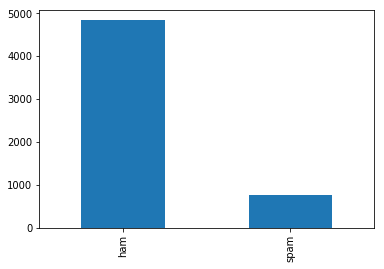

In [7]:
data.label.value_counts().plot.bar();

Add numerical label for spam   
Target must be numerical for ML classification models

In [8]:
data['class'] = data['label'].map( {'spam': 1, 'ham': 0} ).astype(int)
data.head(15)

,label,text,class
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1


Add a new collumn to determine the length of each SMS message

In [9]:
data['length'] = data['text'].apply(len)

In [10]:
data.head(10)

,label,text,class,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1,148
6,ham,Even my brother is not like to speak with me. ...,0,77
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0,160
8,spam,WINNER!! As a valued network customer you have...,1,158
9,spam,Had your mobile 11 months or more? U R entitle...,1,154


Estimate the average number of words in each type of text message

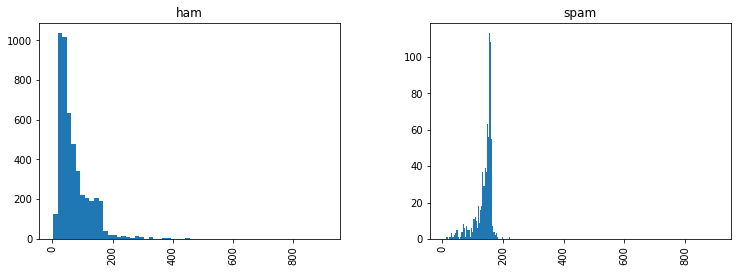

In [11]:
data.hist(column='length',by='label',bins=60,figsize=(12,4));
plt.xlim(-40,950);

Create new datasets of each type of message

In [12]:
data_ham  = data[data['class'] == 0].copy()
data_spam = data[data['class'] == 1].copy()

Display the word clouds to see the occurences of each specific words in each type of text

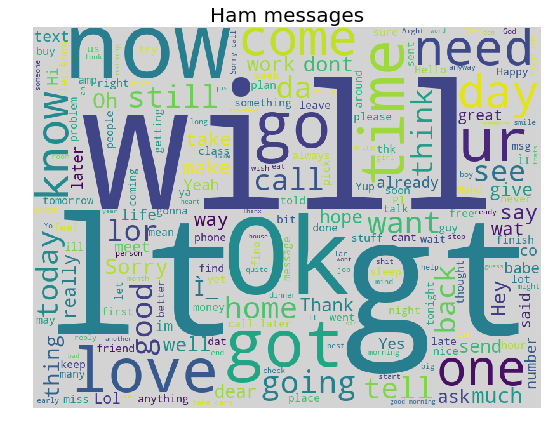

In [13]:
show_wordcloud(data_ham, "Ham messages")

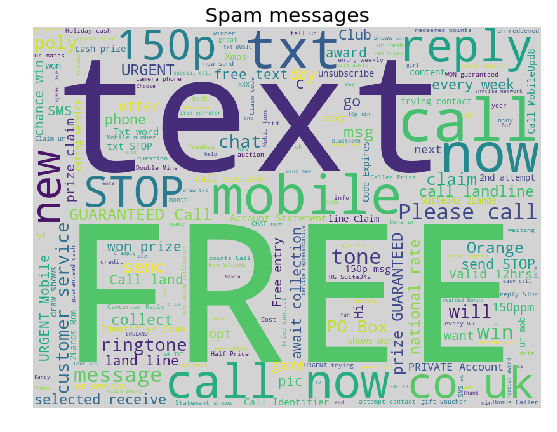

In [14]:
show_wordcloud(data_spam, "Spam messages")

Get string and punction information

In [15]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Load the stop words

In [16]:
from nltk.corpus import stopwords
stopwords.words("english")[100:110]

['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']

Define and run a function to remove these from the text while also converting all text to lowercase

In [17]:
def remove_punctuation_and_stopwords(sms):
    
    sms_no_punctuation = [ch for ch in sms if ch not in string.punctuation]
    sms_no_punctuation = "".join(sms_no_punctuation).split()
    
    sms_no_punctuation_no_stopwords = \
        [word.lower() for word in sms_no_punctuation if word.lower() not in stopwords.words("english")]
        
    return sms_no_punctuation_no_stopwords

In [18]:
data['text'].apply(remove_punctuation_and_stopwords).head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: text, dtype: object

Import necessary libraries to determine the words with the most often occurences in each text type

In [19]:
from collections import Counter

In [20]:
data_ham.loc[:, 'text'] = data_ham['text'].apply(remove_punctuation_and_stopwords)
words_data_ham = data_ham['text'].tolist()
data_spam.loc[:, 'text'] = data_spam['text'].apply(remove_punctuation_and_stopwords)
words_data_spam = data_spam['text'].tolist()

Iterate through each type of message and add all these words to two separate lists

In [21]:
list_ham_words = []
for sublist in words_data_ham:
    for item in sublist:
        list_ham_words.append(item)

In [22]:
list_spam_words = []
for sublist in words_data_spam:
    for item in sublist:
        list_spam_words.append(item)

In [23]:
c_ham  = Counter(list_ham_words)
c_spam = Counter(list_spam_words)
df_hamwords_top30  = pd.DataFrame(c_ham.most_common(30),  columns=['word', 'count'])
df_spamwords_top30 = pd.DataFrame(c_spam.most_common(30), columns=['word', 'count'])

Plot the top words in a graph for visualization

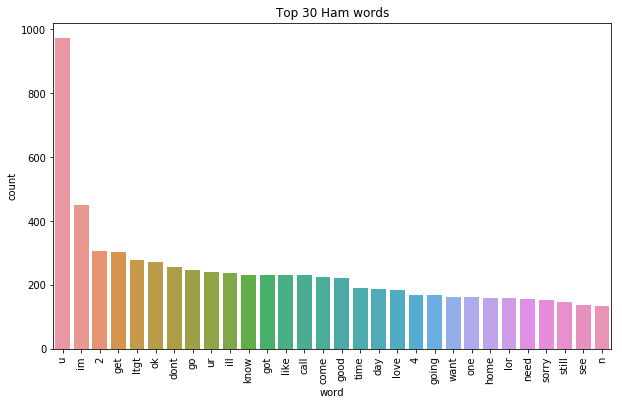

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_hamwords_top30, ax=ax)
plt.title("Top 30 Ham words")
plt.xticks(rotation='vertical');

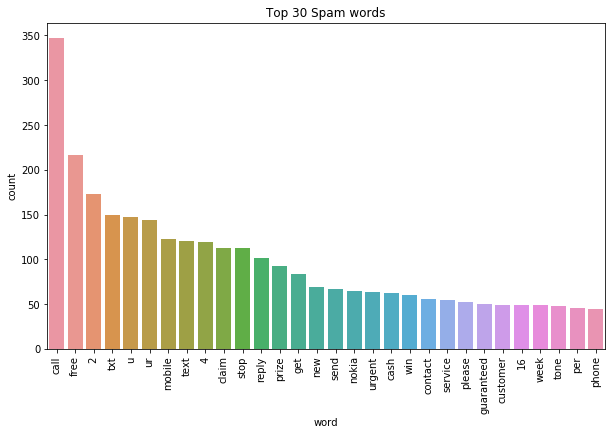

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_spamwords_top30, ax=ax)
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical');

# Part 3: Data Representation

The book "Hands-On Machine Learning with Scikit-Learn and Tensorflow" by Aurélien Géron describes these four ways to help with the extraction of numerical features from text content:

1. **Tokenization** — tokenizing strings by convert sentences to words and assigning an integer id for each possible token  
2. **Vectorization** — counting the occurrences of tokens in each document
3. **TF-IDF** — normalizing and weighting with diminishing importance tokens that occur in the majority of samples / documents
4. **Bag of Words (BOW)** — making the list of unique words which are represented as a vector of 1 for present and 0 for absent from the vocabulary/count the number of times each word appears in a document

Load in the libraries to implement BOW

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer = remove_punctuation_and_stopwords).fit(data['text'])

In [27]:
print(len(bow_transformer.vocabulary_))

9431


Lets look at some vectorization examples for spam and ham messages

In [28]:
sample_spam = data['text'][8]
bow_sample_spam = bow_transformer.transform([sample_spam])
print(sample_spam)
print(bow_sample_spam)

WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
  (0, 218)	1
  (0, 323)	1
  (0, 1906)	1
  (0, 2184)	2
  (0, 2245)	1
  (0, 2531)	1
  (0, 4194)	1
  (0, 4759)	1
  (0, 5707)	1
  (0, 6538)	1
  (0, 6775)	1
  (0, 6946)	1
  (0, 7209)	1
  (0, 8694)	1
  (0, 8698)	1
  (0, 9028)	1
  (0, 9418)	1


In [29]:
rows, cols = bow_sample_spam.nonzero()
for col in cols: 
    print(bow_transformer.get_feature_names()[col])

09061701461
12
call
claim
code
customer
hours
kl341
network
prize
receivea
reward
selected
valid
valued
winner
å£900


In [30]:
sample_ham = data['text'][4]
bow_sample_ham = bow_transformer.transform([sample_ham])
print(sample_ham)
print(bow_sample_ham)

Nah I don't think he goes to usf, he lives around here though
  (0, 1279)	1
  (0, 2882)	1
  (0, 3762)	1
  (0, 5004)	1
  (0, 5631)	1
  (0, 8224)	1
  (0, 8243)	1
  (0, 8664)	1


In [31]:
bow_data = bow_transformer.transform(data['text'])

In [32]:
bow_data.shape[1]

9431

In [33]:
bow_data.nnz

49772

Determine the percentage of non-zero entries in the matrix

In [34]:
print( bow_data.nnz / (bow_data.shape[0] * bow_data.shape[1]) *100 )

0.09471444959776236


# Part 4: Implementing Term Frequency-Inverse Document Frequency (TF-IDF)

According to "Hands-On Machine Learning with Scikit-Learn and Tensorflow" by Aurélien Géron, occurrence count can be a somewhat accurate metric but there is an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics. To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document. This new value is called tf for Term Frequencies. Another refinement on top of tf is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus, which is called tf–idf for term frequency times inverse document frequency.

In [35]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(bow_data)

Lets look at some tf-idf examples for spam and ham messages

In [36]:
tfidf_sample_ham = tfidf_transformer.transform(bow_sample_ham)
print(tfidf_sample_ham)

  (0, 8664)	0.4000611457714059
  (0, 8243)	0.35462891367407595
  (0, 8224)	0.2665748147939407
  (0, 5631)	0.40493594386802356
  (0, 5004)	0.44910913790937335
  (0, 3762)	0.35674330934716636
  (0, 2882)	0.23016324066220836
  (0, 1279)	0.31179198007951625


In [37]:
tfidf_sample_spam = tfidf_transformer.transform(bow_sample_spam)
print(tfidf_sample_spam)

  (0, 9418)	0.2604683359422661
  (0, 9028)	0.23445094204464131
  (0, 8698)	0.24115248419490207
  (0, 8694)	0.22254833340975305
  (0, 7209)	0.2148462495005997
  (0, 6946)	0.2564029044370425
  (0, 6775)	0.2943229069695555
  (0, 6538)	0.178899142428953
  (0, 5707)	0.2148462495005997
  (0, 4759)	0.2943229069695555
  (0, 4194)	0.22555164191980467
  (0, 2531)	0.1915015107445745
  (0, 2245)	0.21371446699888028
  (0, 2184)	0.3406301232141347
  (0, 1906)	0.1153380143353214
  (0, 323)	0.2387711073538672
  (0, 218)	0.2943229069695555


In [38]:
data_tfidf = tfidf_transformer.transform(bow_data)

In [39]:
data_tfidf

<5572x9431 sparse matrix of type '<class 'numpy.float64'>'
	with 49772 stored elements in Compressed Sparse Row format>

In [40]:
np.shape(data_tfidf)

(5572, 9431)

# Part 5: Dealing With Sparsity

"Hands-On Machine Learning with Scikit-Learn and Tensorflow" by Aurélien Géron describes the need to deal with sparse matrices since most documents will typically use a very small subset of the words used in the corpus.

In order to be able to store such a matrix in memory and also speed up algebraic operations with matrices, I will implement a sparse representation such as available in the scipy.sparse package.

In [41]:
from scipy.sparse import  hstack
X2 = hstack((data_tfidf ,np.array(data['length'])[:,None])).A

# Part 6: Natural Language Toolkit (NLTK)

The Natural Language ToolKit is one of the most-used NLP libraries. I iused this for tokenization and removing stop words from the dataset.

In [42]:
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

Lets look at some tokenization examples for spam and ham messages

In [43]:
print(word_tokenize(data['text'][7]))

['As', 'per', 'your', 'request', "'Melle", 'Melle', '(', 'Oru', 'Minnaminunginte', 'Nurungu', 'Vettam', ')', "'", 'has', 'been', 'set', 'as', 'your', 'callertune', 'for', 'all', 'Callers', '.', 'Press', '*9', 'to', 'copy', 'your', 'friends', 'Callertune']


In [44]:
print(sent_tokenize(data['text'][7]))

["As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers.", 'Press *9 to copy your friends Callertune']


In [45]:
print(data['text'][7])

As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


Use NLTK to filter out the stop words from the dataset

In [46]:
stopWords = set(stopwords.words('english'))
words = word_tokenize(data['text'][7])
wordsFiltered = []

for w in words:
    if w not in stopWords:
        wordsFiltered.append(w)

print(wordsFiltered)

['As', 'per', 'request', "'Melle", 'Melle', '(', 'Oru', 'Minnaminunginte', 'Nurungu', 'Vettam', ')', "'", 'set', 'callertune', 'Callers', '.', 'Press', '*9', 'copy', 'friends', 'Callertune']


# Part 7: Splitting the Data Set

Split the dataset into train data and validation data

In [47]:
xtrain, xvalid, ytrain, yvalid = train_test_split(data.text.values, data["class"], 
                                                  stratify=data["class"])

# Part 8: Switch To Word Embeddings

One of the major disadvantages I learned about with regards to using BOW is that it discards word order, thereby ignoring the context and in turn meaning of words in the document. To solve this problem I will use a different approach called word embedding, which allows for a representation of text where words that have the same meaning have a similar representation. In other words, it represents words in a coordinate system where related words, based on a corpus of relationships, are placed closer together.

In [48]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open("../input/glove6b50dtxt/glove.6B.50d.txt")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:07, 52811.14it/s]

Found 400000 word vectors.


This function creates a normalized vector for the whole sentence

In [49]:
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

Create sentence vectors using the above function for training and validation set



In [50]:
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

100%|██████████| 1393/1393 [00:00<00:00, 2616.50it/s]


In [51]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

# Part 9: Deep Learning

Train two recurrent neural network models — one LSTM and one GRU — in order to determine which model will better work with the dataset.

In [52]:
ytrain_enc = np_utils.to_categorical(ytrain)
yvalid_enc = np_utils.to_categorical(yvalid)

Use keras tokenizer and zero pad the sequences

In [53]:
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

Create an embedding matrix for the words in the dataset



In [54]:
embedding_matrix = np.zeros((len(word_index) + 1, 50))
for word, i in word_index.items():
    if i < 40000:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Part 10: LSTM

A  bidirectional LSTM with glove embeddings and two dense layers

In [55]:
# LSTM Model

model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     50,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=20, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc))

Train on 4179 samples, validate on 1393 samples
Epoch 1/20
4179/4179 [==============================] - 6s 1ms/step - loss: 0.4262 - acc: 0.8264 - val_loss: 0.2972 - val_acc: 0.8658
Epoch 2/20
4179/4179 [==============================] - 3s 765us/step - loss: 0.2680 - acc: 0.8660 - val_loss: 0.1981 - val_acc: 0.8658
Epoch 3/20
4179/4179 [==============================] - 3s 738us/step - loss: 0.1956 - acc: 0.8905 - val_loss: 0.1736 - val_acc: 0.9487
Epoch 4/20
4179/4179 [==============================] - 3s 771us/step - loss: 0.1746 - acc: 0.9444 - val_loss: 0.1392 - val_acc: 0.9505
Epoch 5/20
4179/4179 [==============================] - 3s 752us/step - loss: 0.1443 - acc: 0.9518 - val_loss: 0.1165 - val_acc: 0.9616
Epoch 6/20
4179/4179 [==============================] - 3s 733us/step - loss: 0.1360 - acc: 0.9547 - val_loss: 0.1127 - val_acc: 0.9623
Epoch 7/20
4179/4179 [==============================] - 4s 895us/step - loss: 0.1339 - acc: 0.9544 - val_loss: 0.1320 - val_acc: 0.9591
Ep

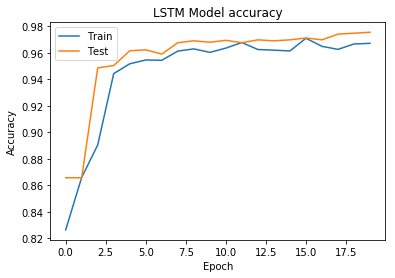

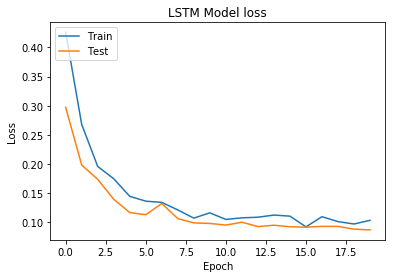

In [56]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('LSTM Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Part 11: GRU

A  bidirectional GRU with glove embeddings and two dense layers

In [57]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     50,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(GRU(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=20, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc))

Train on 4179 samples, validate on 1393 samples
Epoch 1/20
4179/4179 [==============================] - 5s 1ms/step - loss: 0.4197 - acc: 0.8126 - val_loss: 0.2960 - val_acc: 0.8658
Epoch 2/20
4179/4179 [==============================] - 3s 619us/step - loss: 0.2931 - acc: 0.8660 - val_loss: 0.2566 - val_acc: 0.8658
Epoch 3/20
4179/4179 [==============================] - 3s 645us/step - loss: 0.2365 - acc: 0.8746 - val_loss: 0.2045 - val_acc: 0.9555
Epoch 4/20
4179/4179 [==============================] - 3s 613us/step - loss: 0.2134 - acc: 0.9229 - val_loss: 0.1749 - val_acc: 0.9444
Epoch 5/20
4179/4179 [==============================] - 3s 673us/step - loss: 0.1561 - acc: 0.9469 - val_loss: 0.1347 - val_acc: 0.9612
Epoch 6/20
4179/4179 [==============================] - 3s 669us/step - loss: 0.1488 - acc: 0.9478 - val_loss: 0.1228 - val_acc: 0.9591
Epoch 7/20
4179/4179 [==============================] - 3s 640us/step - loss: 0.1299 - acc: 0.9561 - val_loss: 0.1054 - val_acc: 0.9691
Ep

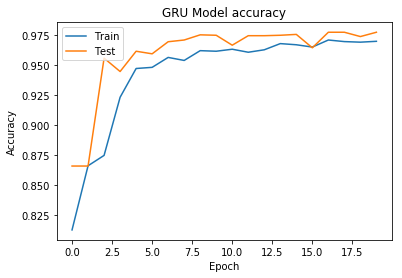

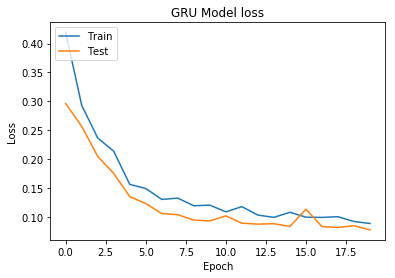

In [58]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('GRU Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('GRU Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()